## Get data and create train and test sets

In [5]:
from sklearn.datasets import fetch_openml
#Sets as_frame=False to get as a numpy array insted of pandasDF
mnist = fetch_openml("mnist_784", as_frame=False)
X,y= mnist.data, mnist.target
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Pipelines

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier


#Preprocessing
preprocessing_pipeline = Pipeline([
    ('scaler',StandardScaler())
])

#KNN, values assigned by values from lab4
knn_pipeline = Pipeline([
    ('knn', KNeighborsClassifier(n_neighbors= 4, weights='distance' ,n_jobs=-1))
])

# SGD, values assigned by values from lab4
sgd_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('sgd',SGDClassifier(loss='hinge',penalty='l2', alpha=0.0001, eta0=0.01,  n_jobs=-1, random_state=120))
])

#Random Forest, values assigned by values from lab4
random_forest_pipeline = Pipeline([
    ("preprocessing", preprocessing_pipeline),
    ('random_forest', RandomForestClassifier(n_estimators=2000, max_depth=20, min_samples_split=2 ,n_jobs=-1, random_state=120))
])

#SVM
svc_pipeline = Pipeline([
    ("preprocessing", preprocessing_pipeline),
    ("svc", SVC())
])

## GridSearch for SVC

Setup the parameter grid

In [7]:
svc_param_grid = [
    {
        'svc__kernel': ['linear'],
        'svc__C': [0.1, 1, 10]
    },
    {
        'svc__kernel': ['poly'],
        'svc__C': [0.1, 1, 10],
        'svc__degree': [2, 3, 4],
        'svc__coef0': [0.0, 0.5, 1.0]
    },
    {
        'svc__kernel': ['rbf'],
        'svc__C': [0.1, 1, 10],
        'svc__gamma': [0.001, 0.01, 0.1]}
]

Run grid search

In [8]:
from sklearn.model_selection import GridSearchCV

svc_grid_search = GridSearchCV(svc_pipeline, svc_param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
svc_grid_search.fit(X_train, y_train)
# Sets a variable to save the best parameters, is used later when writing to excel
svc_best_params = {'SVM': svc_grid_search.best_params_}
svc_best = svc_grid_search.best_estimator_
y_pred_svc = svc_best.predict(X_test)

Fitting 5 folds for each of 39 candidates, totalling 195 fits


\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Export all the parameters tested from grid search to excel

In [25]:
import pandas as pd

# Create a DataFrame from cv_results_ to see all tested parameters and related metrics
results_df = pd.DataFrame(svc_grid_search.cv_results_)

# Save the DataFrame to an Excel file
results_df.to_excel('svc_grid_search_results.xlsx', index=False)

## Train and display metrics

Creates a dict for classifiers

In [9]:
classifiers = {
    'SVC': svc_best,
    'KNN': knn_pipeline,
    'Random Forest': random_forest_pipeline,
    'SGD': sgd_pipeline
}

Creates a empty metric dict to store all the metrics

In [10]:
# dict to store individual metrics
metrics = {
    'Classifier': [], 
    'Accuracy': [], 
    'Precision': [], 
    'Recall': [], 
    'F1-score': [],
    'Compute Time (s)': []
}

# dict to save the classification report for each model
classification_reports = {}

Run all the classifiers set in the dict above and save the metrics in the metrics dict

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import time

#loop through the classifier dict and run all the metrics
for name, clf in classifiers.items():
    # start timer
    start_time = time.time()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    # end timer
    end_time = time.time()
    # Calculate the compute time
    compute_time = end_time - start_time

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    metrics['Classifier'].append(name)
    metrics['Accuracy'].append(accuracy)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['F1-score'].append(f1)
    metrics['Compute Time (s)'].append(compute_time)

    classification_reports[name] = classification_report(y_test, y_pred, output_dict=True, zero_division=0)


## Save the metrics to excel

In [20]:
import pandas as pd

#Convert the metrics to pandas DataFrame
metrics_df = pd.DataFrame(metrics)

with pd.ExcelWriter('classification_metrics.xlsx') as writer:
    metrics_df.to_excel(writer, sheet_name='Metrics', index=False)
    best_params_df = pd.DataFrame.from_dict(svc_best_params, orient='index')
    best_params_df.to_excel(writer, sheet_name='Best Parameters')
    for name, report in classification_reports.items():
        report_df = pd.DataFrame(report).transpose()
        report_df.to_excel(writer, sheet_name=f'{name}_Report')

## Create Figures & Save

#### Define a function for plotting and saving

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

#Change the font and text size
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size': 10})

# function to plot bar chart
def plot_metric(metric_name, ylabel, filename, data):
    plt.figure(figsize=(3.5, 2.5))
    sns.barplot(x='Classifier', y=metric_name, data=data)
    plt.ylabel(ylabel, fontsize=10)
    plt.savefig(filename, bbox_inches='tight')


# Function for plotting boxplot
def plot_boxplot(metric_name, ylabel, filename):
    plt.figure(figsize=(3.5, 2.5))
    sns.boxplot(x='Classifier', y=metric_name, data=metrics_df)
    plt.ylabel(ylabel, fontsize=10)
    plt.savefig(filename, bbox_inches='tight')

#### Using the function and save the figures

Metrics

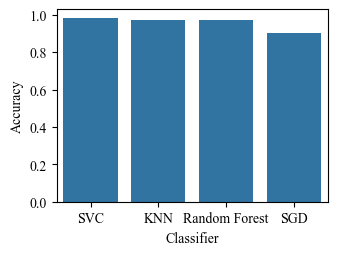

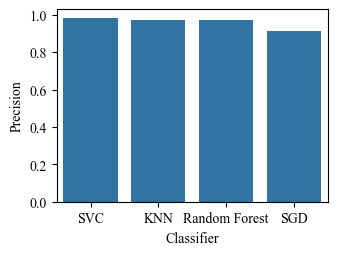

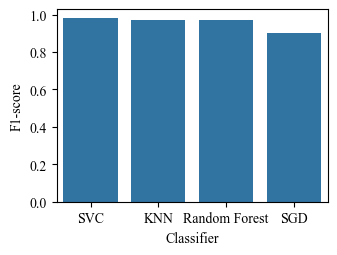

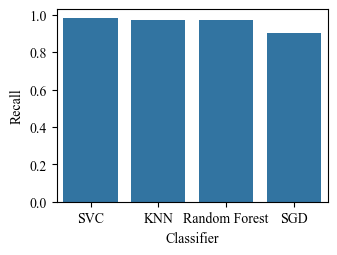

In [14]:
plot_metric('Accuracy', 'Accuracy', 'accuracy_comparison.png', data=metrics_df)
plot_metric('Precision', 'Precision', 'precision_comparison.png', data=metrics_df)
plot_metric('F1-score', 'F1-score', 'f1score_comparison.png', data=metrics_df)
plot_metric('Recall', 'Recall', 'recall_comparison.png', data=metrics_df)

Plot boxplots

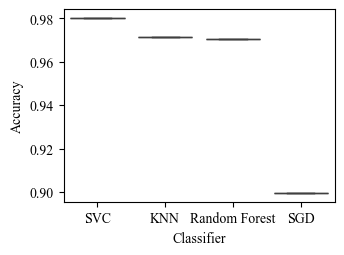

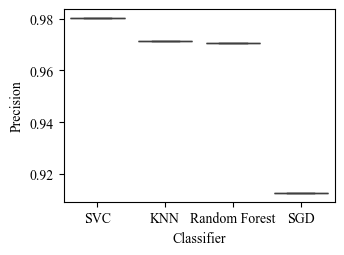

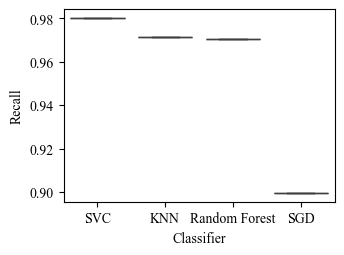

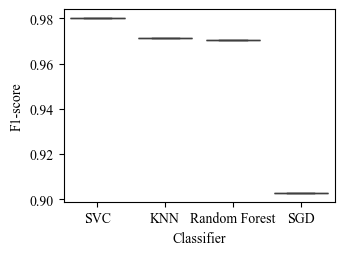

In [15]:
plot_boxplot('Accuracy', 'Accuracy', 'accuracy_boxplot.png')
plot_boxplot('Precision', 'Precision', 'precision_boxplot.png')
plot_boxplot('Recall', 'Recall', 'recall_boxplot.png')
plot_boxplot('F1-score', 'F1-score', 'f1score_boxplot.png')

## Learning curves

#### Function to plot learning curves

In [16]:

from sklearn.model_selection import learning_curve
import numpy as np
# Function to plot learning curve, setting the linspace to 5 gives samples from 10%, 32.5%, 55%, 77.5%, 100% of the training data. Increase if needed
def plot_learning_curve(estimator, title, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure(figsize=(6, 4))
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy'
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    plt.grid()
    plt.savefig(f'{title.lower().replace(" ", "_")}_learning_curve.png', bbox_inches='tight')

Call the curve functions

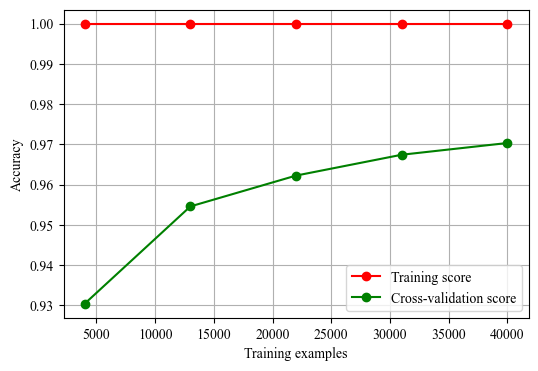

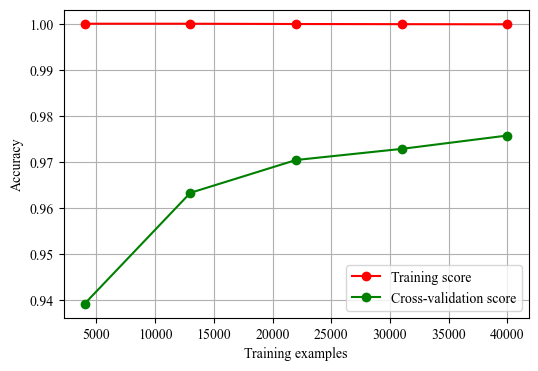

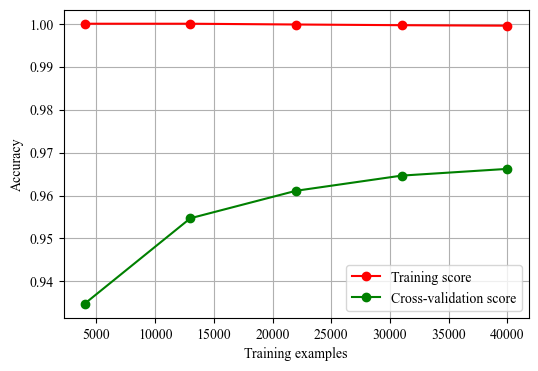

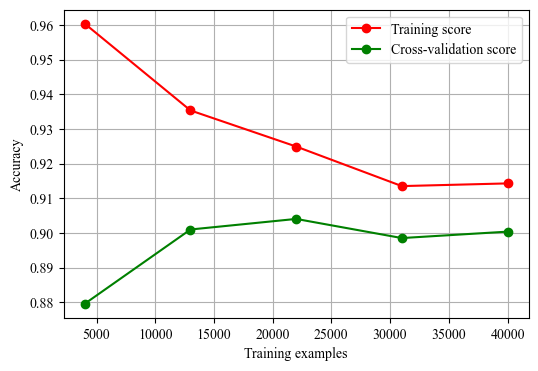

In [17]:
plot_learning_curve(knn_pipeline, "KNN Learning Curve", X_train, y_train)
plot_learning_curve(svc_best, "SVM Learning Curve", X_train, y_train)
plot_learning_curve(random_forest_pipeline, "Random Forest Learning Curve", X_train, y_train)
plot_learning_curve(sgd_pipeline, "SGD Learning Curve", X_train, y_train)

## Confusion matrix

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(estimator, X_test, y_test, title):
    y_pred = estimator.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(cmap='viridis', values_format='d', ax=plt.gca())
    plt.savefig(f'{title.lower().replace(" ", "_")}_confusion_matrix.png', bbox_inches='tight')
    cm_df = pd.DataFrame(cm, index=np.unique(y_test), columns=np.unique(y_test))
    excel_filename = f'{title.lower().replace(" ", "_")}_confusion_matrix.xlsx'
    cm_df.to_excel(excel_filename)


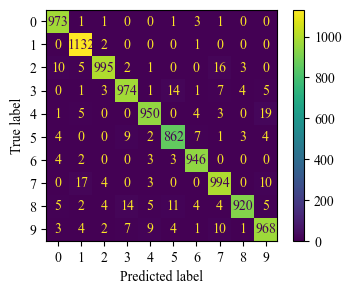

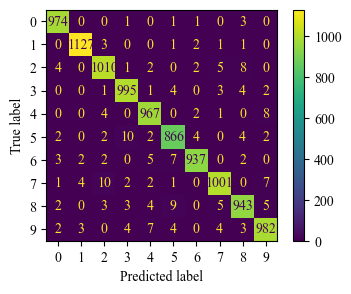

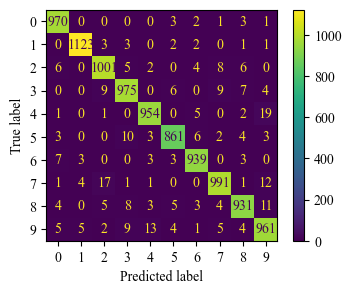

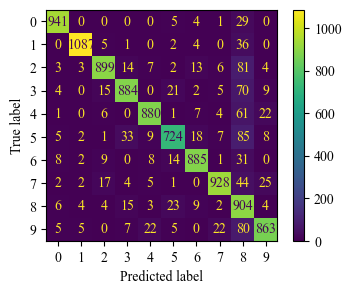

In [27]:
plot_confusion_matrix(knn_pipeline, X_test, y_test, "KNN Confusion Matrix")
plot_confusion_matrix(svc_best, X_test, y_test, "SVM Confusion Matrix")
plot_confusion_matrix(random_forest_pipeline, X_test, y_test, "Random Forest Confusion Matrix")
plot_confusion_matrix(sgd_pipeline, X_test, y_test, "SGD Confusion Matrix")